<a href="https://colab.research.google.com/github/skj092/Real-vs-Fake-image/blob/main/Fake_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the Dataset

In [23]:
# %%bash
!mkdir ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

!cp kaggle.json ~/.kaggle

!kaggle datasets download -d sophatvathana/casia-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
casia-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q /content/casia-dataset.zip

# Data Preprocessing 

In [16]:
import tensorflow as tf
import cv2, os
import numpy as np
from tensorflow.keras.applications import xception

def process(path):
    quality, scale = 95, 15
    labels = np.array(['Au', 'Tp'])
    parts = tf.strings.split(path, os.path.sep)
    one_hot = parts[-2] == labels
    # label encoding 
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)
    # read the image
    img = cv2.imread(path.numpy().decode('utf-8'))
    # img = cv2.imread(path)
    # resize to 224x224
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # save it in buffer
    _, buffer = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    # convert to numpy array
    buffer = np.frombuffer(buffer, dtype=np.uint8)
    # decode the image
    compressed = cv2.imdecode(buffer, cv2.IMREAD_COLOR)
    # computer the absolute difference
    diff = (cv2.absdiff(img, compressed)) * scale
    img = xception.preprocess_input(diff)
    return img, label

# test
# path = "CASIA2/Au/Au_ani_00001.jpg"
# path = "/content/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif"
# img, label = process(path)
# print(img.shape, label)


In [17]:
import tensorflow as tf
# from utils import process

# path of the dataset
data_dir = '/content/CASIA2/'
# Collecting the data
jpg_files = tf.data.Dataset.list_files(str(data_dir + '**/*.jpg'))
tif_files = tf.data.Dataset.list_files(str(data_dir + '**/*.tif'))

# Creating the dataset
dataset = jpg_files.concatenate(tif_files)
print('number of images: ', len(list(dataset)))

# processing the data
preprocess = lambda x: tf.py_function(process, [x], [tf.float32, tf.float32])

# creating the dataset for training and validation
n_data = dataset.cardinality().numpy()
train_size = int(0.8 * n_data)
val_size = n_data - train_size

train_dataset = dataset.take(train_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(train_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling the data
train_dataset = train_dataset.shuffle(1000)
val_dataset = val_dataset.shuffle(1000)
# batching the data
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

number of images:  12477


In [18]:
for xb, yb in train_dataset:
  print(xb.shape, yb.shape)
  break 

(32, 224, 224, 3) (32,)


In [28]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras import Sequential,Model

def pretrained_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    return model

In [33]:
def cnn():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'softmax'))
    return model

model = cnn()

In [40]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [41]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name="SGD")

In [43]:
# compiling the model
model = pretrained_model()
model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

In [44]:
history = model.fit(train_dataset,epochs=6,batch_size=32, validation_data=val_dataset)

Epoch 1/6
312/312 [==============================] - 340s 1s/step - loss: 0.4721 - accuracy: 0.0962 - precision: 0.7797 - recall: 0.1051 - auc: 0.8005 - prc: 0.5835 - val_loss: 0.7439 - val_accuracy: 0.0256 - val_precision: 1.0000 - val_recall: 0.6651 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/6
312/312 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.1506 - precision: 0.8261 - recall: 0.4576 - auc: 0.9142 - prc: 0.7824

KeyboardInterrupt: ignored

## Fastai

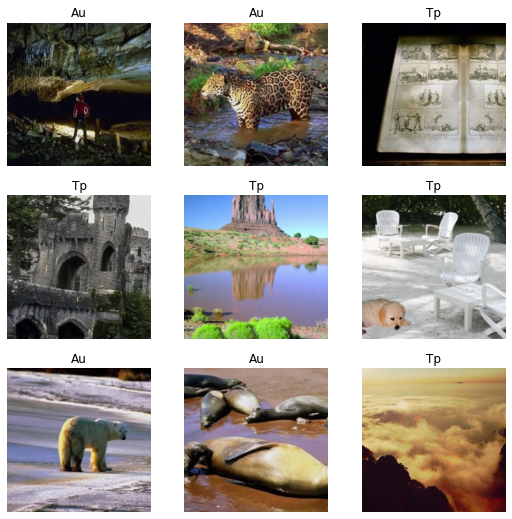

In [1]:
# importing fastai library
from fastai.vision.all import *

# root directory
path = Path('/content/CASIA2')

# creating a datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items=get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=parent_label,
                        item_tfms=Resize(224))

# creating a dataloader
dls = dblock.dataloaders(path)

# testing the dataloader
dls.show_batch()

In [ ]:
# creating a vision learner
learn = vision_learner(dls, resnet18, metrics=accuracy)

# training the model
learn.fine_tune(4)

In [5]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=af3a0be023cf204d0367d595a6ae9584e9dfceea4aacd8ff2716830281787147
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [6]:
# importing efficientnet_pytorch library`
from efficientnet_pytorch import EfficientNet

# creating a custom model with efficientnet
model = EfficientNet.from_pretrained('efficientnet-b0')

# creating a learner
learn = Learner(dls, model, metrics=accuracy)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
learn.fit_one_cycle(5)

In [10]:
# converting image to ela image
from glob import glob 
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import os 

def convert_to_ela_image(image_path, quality=90):
    """Converts an image to an ELA image.
    :param image_path: Path to the image
    :param quality: Quality of the image to be saved
    :return: ELA image
    """
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path)
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [12]:
# converting all images to ela images
all_images = glob('/content/CASIA2/*/*')

print('Total number of images are : ', len(all_images))

# creating a directory to store ela images
if not os.path.exists('archive/CASIA2_ELA'):
    os.makedirs('archive/CASIA2_ELA')

for image in tqdm(all_images):
    ela_image = convert_to_ela_image(image)
    ela_image.save(image.replace('CASIA2', 'CASIA2_ELA'))

Total number of images are :  12616


  0%|          | 0/12616 [00:00<?, ?it/s]


FileNotFoundError: ignored